# HM5: Build a Supervised Autoencoder.

### Name: WenboCao



PCA and the standard autoencoder are unsupervised dimensionality reduction methods, and their learned features are not discriminative. If you build a classifier upon the low-dimenional features extracted by PCA and autoencoder, you will find the classification accuracy very poor.

Linear discriminant analysis (LDA) is a traditionally supervised dimensionality reduction method for learning low-dimensional features which are highly discriminative. Likewise, can we extend autoencoder to supervised leanring?



**You are required to build and train a supervised autoencoder look like the following.** You are required to add other layers properly to alleviate overfitting.


![Network Structure](https://github.com/wangshusen/CS583A-2019Spring/blob/master/homework/HM5/supervised_ae.png?raw=true "NetworkStructure")


## 0. You will do the following:

1. Read and run my code to train a standard dense autoencoder.

2. Build and train a supervised autoencoder, visual the low-dim features and the reconstructions, and evaluate whether the learned low-dim features are discriminative.
    
3. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain the code and the output after execution.
    
    
    
4. Upload this .HTML file to your Google Drive, Dropbox, or Github repo.

4. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2019F/blob/master/homework/HM5/HM5.html


## 1. Data preparation

### 1.1. Load data


In [1]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(60000, 28*28).astype('float32') / 255.
x_test = x_test.reshape(10000, 28*28).astype('float32') / 255.

print('Shape of x_train: ' + str(x_train.shape)) 
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Using TensorFlow backend.


11493376/11490434 [==============================] - 2s 0us/step
Shape of x_train: (60000, 784)
Shape of x_test: (10000, 784)
Shape of y_train: (60000,)
Shape of y_test: (10000,)


### 1.2. One-hot encode the labels

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transform such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Define a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Apply the function to ```y_train``` and ```y_test```.

In [2]:
import numpy

def to_one_hot(y, num_class=10):
    results = numpy.zeros((len(y), num_class))
    for i, label in enumerate(y):
        results[i, label] = 1.
    return results

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (60000, 10)
Shape of y_test_vec: (10000, 10)
5
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


### 1.3. Randomly partition the training set to training and validation sets

Randomly partition the 60K training samples to 2 sets:
* a training set containing 10K samples
* a validation set containing 50K samples


In [3]:
rand_indices = numpy.random.permutation(60000)
train_indices = rand_indices[0:10000]
valid_indices = rand_indices[10000:20000]

x_val = x_train[valid_indices, :]
y_val = y_train_vec[valid_indices, :]

x_tr = x_train[train_indices, :]
y_tr = y_train_vec[train_indices, :]

print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

Shape of x_tr: (10000, 784)
Shape of y_tr: (10000, 10)
Shape of x_val: (10000, 784)
Shape of y_val: (10000, 10)


## 2. Build an unsupervised  autoencoder and tune its hyper-parameters

1. Build a dense autoencoder model
2. Use the validation data to tune the hyper-parameters (e.g., network structure, and optimization algorithm)
    * Do NOT use test data for hyper-parameter tuning!!!
    
3. Try to achieve a validation loss as low as possible.
4. Evaluate the model on the test set.
5. Visualize the low-dim features and reconstructions.

### 2.1. Build the model

In [4]:
from keras.layers import Dense, Input
from keras import models

input_img = Input(shape=(784,), name='input_img')

encode1 = Dense(128, activation='relu', name='encode1')(input_img)
encode2 = Dense(32, activation='relu', name='encode2')(encode1)
encode3 = Dense(8, activation='relu', name='encode3')(encode2)
bottleneck = Dense(2, activation='relu', name='bottleneck')(encode3)
decode1 = Dense(8, activation='relu', name='decode1')(bottleneck)
decode2 = Dense(32, activation='relu', name='decode2')(decode1)
decode3 = Dense(128, activation='relu', name='decode3')(decode2)
decode4 = Dense(784, activation='relu', name='decode4')(decode3)

ae = models.Model(input_img, decode4)

ae.summary()




Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 784)               0         
_________________________________________________________________
encode1 (Dense)              (None, 128)               100480    
_________________________________________________________________
encode2 (Dense)              (None, 32)                4128      
_________________________________________________________________
encode3 (Dense)              (None, 8)                 264       
_________________________________________________________________
bottleneck (Dense)           (None, 2)                 18        
_________________________________________________________________
decode1 (Dense)              (None, 8)                 24        
_________________________________________________________________
decode2 (Dense)              (None, 32)                2

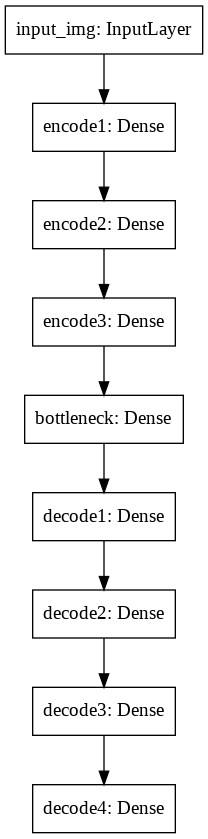

In [5]:
# print the network structure to a PDF file

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

SVG(model_to_dot(ae, show_shapes=False).create(prog='dot', format='svg'))

plot_model(
    model=ae, show_shapes=False,
    to_file='unsupervised_ae.png'
)

# you can find the file "unsupervised_ae.pdf" in the current directory.

### 2.2. Train the model and tune the hyper-parameters

In [6]:
from keras import optimizers

learning_rate = 1E-4 # to be tuned!

ae.compile(loss='mean_squared_error',
           optimizer=optimizers.RMSprop(lr=learning_rate))

In [7]:
history = ae.fit(x_tr, x_tr, 
                 batch_size=128, 
                 epochs=100, 
                 validation_data=(x_val, x_val))




Train on 10000 samples, validate on 10000 samples
Epoch 1/100





10000/10000 [==============================] - 5s 538us/step - loss: 0.0941 - val_loss: 0.0849
Epoch 2/100
10000/10000 [==============================] - 0s 48us/step - loss: 0.0832 - val_loss: 0.0826
Epoch 3/100
10000/10000 [==============================] - 0s 47us/step - loss: 0.0814 - val_loss: 0.0805
Epoch 4/100
10000/10000 [==============================] - 0s 49us/step - loss: 0.0792 - val_loss: 0.0785
Epoch 5/100
10000/10000 [==============================] - 0s 48us/step - loss: 0.0771 - val_loss: 0.0761
Epoch 6/100
10000/10000 [==============================] - 1s 50us/step - loss: 0.0753 - val_loss: 0.0749
Epoch 7/100
10000/10000 [==============================] - 0s 49us/step - loss: 0.0741 - val_loss: 0.0739
Epoch 8/100
10000/10000 [==============================] - 0s 50us/step - loss: 0.0733 - val_loss: 0.0732
Epoch 9/100
10000/10000 [==============================] - 0s 48us/step - loss: 0.0727 - val_

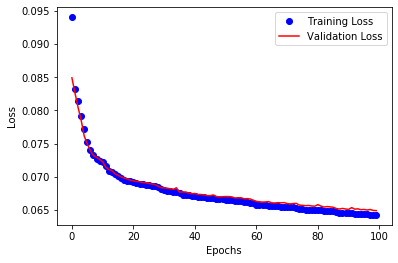

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 2.3. Visualize the reconstructed test images

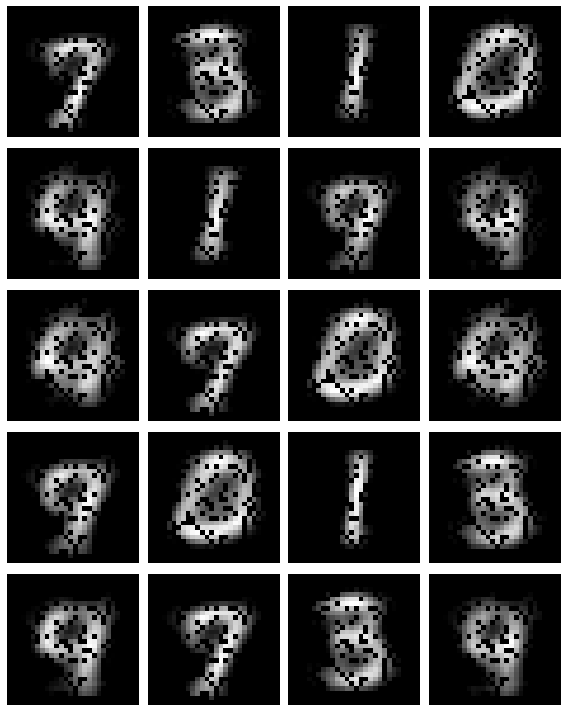

In [9]:
ae_output = ae.predict(x_test).reshape((10000, 28, 28))

ROW = 5
COLUMN = 4

x = ae_output
fname = 'reconstruct_ae.pdf'

fig, axes = plt.subplots(nrows=ROW, ncols=COLUMN, figsize=(8, 10))
for ax, i in zip(axes.flat, numpy.arange(ROW*COLUMN)):
    image = x[i].reshape(28, 28)
    ax.imshow(image, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.savefig(fname)
plt.show()

### 2.4. Evaluate the model on the test set

Do NOT used the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [10]:
loss = ae.evaluate(x_test, x_test)
print('loss = ' + str(loss))

10000/10000 [==============================] - 0s 38us/step
loss = 0.0650426355957985


### 2.5. Visualize the low-dimensional features

In [11]:
# build the encoder network
ae_encoder = models.Model(input_img, bottleneck)
ae_encoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 784)               0         
_________________________________________________________________
encode1 (Dense)              (None, 128)               100480    
_________________________________________________________________
encode2 (Dense)              (None, 32)                4128      
_________________________________________________________________
encode3 (Dense)              (None, 8)                 264       
_________________________________________________________________
bottleneck (Dense)           (None, 2)                 18        
Total params: 104,890
Trainable params: 104,890
Non-trainable params: 0
_________________________________________________________________


In [12]:
# extract low-dimensional features from the test data
encoded_test = ae_encoder.predict(x_test)
print('Shape of encoded_test: ' + str(encoded_test.shape))

Shape of encoded_test: (10000, 2)


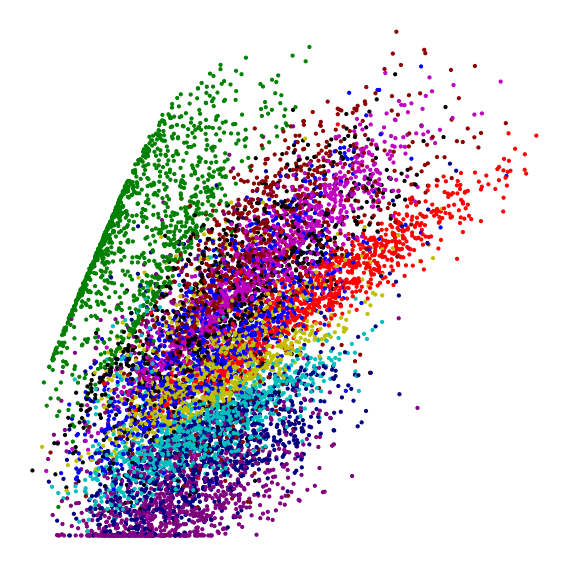

In [13]:
colors = numpy.array(['r', 'g', 'b', 'm', 'c', 'k', 'y', 'purple', 'darkred', 'navy'])
colors_test = colors[y_test]


import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8, 8))
plt.scatter(encoded_test[:, 0], encoded_test[:, 1], s=10, c=colors_test, edgecolors=colors_test)
plt.axis('off')
plt.tight_layout()
fname = 'ae_code.pdf'
plt.savefig(fname)

#### Remark:

Judging from the visualization, the low-dim features seems not discriminative, as 2D features from different classes are mixed. Let quantatively find out whether they are discriminative.

## 3. Are the learned low-dim features discriminative?

To find the answer, lets train a classifier on the training set (the extracted 2-dim features) and evaluation on the test set.

In [14]:
# extract the 2D features from the training, validation, and test samples
f_tr = ae_encoder.predict(x_tr)
f_val = ae_encoder.predict(x_val)
f_te = ae_encoder.predict(x_test)

print('Shape of f_tr: ' + str(f_tr.shape))
print('Shape of f_te: ' + str(f_te.shape))

Shape of f_tr: (10000, 2)
Shape of f_te: (10000, 2)


In [15]:
from keras.layers import Dense, Input
from keras import models

input_feat = Input(shape=(2,))

hidden1 = Dense(128, activation='relu')(input_feat)
hidden2 = Dense(128, activation='relu')(hidden1)
output = Dense(10, activation='softmax')(hidden2)

classifier = models.Model(input_feat, output)

classifier.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               384       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 18,186
Trainable params: 18,186
Non-trainable params: 0
_________________________________________________________________


In [16]:
classifier.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.RMSprop(lr=1E-4),
                  metrics=['acc'])

history = classifier.fit(f_tr, y_tr, 
                        batch_size=32, 
                        epochs=30, 
                        validation_data=(f_val, y_val))


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 10000 samples, validate on 10000 samples
Epoch 1/30
10000/10000 [==============================] - 2s 151us/step - loss: 2.1467 - acc: 0.2757 - val_loss: 1.8607 - val_acc: 0.3399
Epoch 2/30
10000/10000 [==============================] - 1s 133us/step - loss: 1.7703 - acc: 0.3919 - val_loss: 1.6956 - val_acc: 0.4097
Epoch 3/30
10000/10000 [==============================] - 1s 125us/step - loss: 1.6552 - acc: 0.4309 - val_loss: 1.6128 - val_acc: 0.4574
Epoch 4/30
10000/10000 [==============================] - 1s 133us/step - loss: 1.5940 - acc: 0.4461 - val_loss: 1.5666 - val_acc: 0.4711
Epoch 5/30
10000/10000 [==============================] - 1s 128us/step - loss: 1.5497 - acc: 0.4631 - val_loss: 1.5267 - val_acc: 0.4517
Epoch 6/30
10000/10000 [==============================] - 1s 135us/step - loss: 1.5146 - acc: 0.4694 - val_loss: 1.4998 - val_acc: 0.4642
Epoch 7/30
10000/10000 [===

### Conclusion

Using the 2D features, the validation accuracy is 60~70%. Recall that using the original data, the accuracy is about 98%. Obviously, the 2D features are not very discriminative.

We are going to build a supervised autoencode model for learning low-dimensional discriminative features.

## 4. Build a supervised autoencoder model


**You are required to build and train a supervised autoencoder look like the following.** (Not necessary the same.) You are required to add other layers properly to alleviate overfitting.


![Network Structure](https://github.com/wangshusen/CS583A-2019Spring/blob/master/homework/HM5/supervised_ae.png?raw=true "NetworkStructure")


### 4.1. Build the network

In [0]:
# build the supervised autoencoder network
from keras.layers import Dense, Input,Flatten,Dropout,Conv2D,Reshape,BatchNormalization,MaxPooling2D,UpSampling2D
from keras import models

input_img = Input(shape=(784,), name='input_img')

# encoder network
denseInput = Reshape(target_shape=(28,28,1))(input_img)

conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',name='encode_conv1')(denseInput) #28 x 28 x 32
conv1 = BatchNormalization()(conv1)
conv1 = Dropout(0.3)(conv1)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',name='encode_conv11')(conv1)
conv1 = BatchNormalization()(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',name='encode_conv2')(pool1) #14 x 14 x 64
conv2 = BatchNormalization()(conv2)
conv2 = Dropout(0.3)(conv2)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',name='encode_conv21')(conv2)
conv2 = BatchNormalization()(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same',name='encode_conv3')(pool2) #7 x 7 x 128 (small and thick)
conv3 = BatchNormalization()(conv3)
conv3 = Dropout(0.3)(conv3)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same',name='encode_conv31')(conv3)
conv3 = BatchNormalization()(conv3)
d3 = Flatten()(conv3)
bottleneck = Dense(2)(d3)

#decoder
decode_input = Dense(7*7*128)(bottleneck)
decode_input2 = Reshape((7,7,128))(decode_input)
conv5 = Conv2D(128, (3, 3), activation='relu', padding='same',name='encode_conv51')(decode_input2) #7 x 7 x 128
conv5 = BatchNormalization()(conv5)
#conv5 = Dropout(0.3)(conv5)
conv5 = Conv2D(128, (3, 3), activation='relu', padding='same',name='encode_conv52')(conv5)
conv5 = BatchNormalization()(conv5)
#conv5 = Dropout(0.3)(conv5)
conv6 = Conv2D(64, (3, 3), activation='relu', padding='same',name='encode_conv61')(conv5) #7 x 7 x 64
conv6 = BatchNormalization()(conv6)
#conv6 = Dropout(0.3)(conv6)
conv6 = Conv2D(64, (3, 3), activation='relu', padding='same',name='encode_conv62')(conv6)
conv6 = BatchNormalization()(conv6)
up1 = UpSampling2D((2,2))(conv6) #14 x 14 x 64

out_dense1 = Flatten()(up1)
out_dense2 = Dense(1024,activation='relu')(out_dense1)
decoded = Dense(784,activation='relu',name='decode_output')(out_dense2)

# classifier
dense_1 = Dense(128)(bottleneck)
dropout_1 = Dropout(0.5)(dense_1)
dense_2 = Dense(64,)(dropout_1)
classifier3 = Dense(10,activation='sigmoid',name='classifier_output')(dense_2)


In [31]:
# connect the input and the two outputs
sae = models.Model(input_img, [decoded, classifier3])

sae.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          (None, 784)          0                                            
__________________________________________________________________________________________________
reshape_4 (Reshape)             (None, 28, 28, 1)    0           input_img[0][0]                  
__________________________________________________________________________________________________
encode_conv1 (Conv2D)           (None, 28, 28, 32)   320         reshape_4[0][0]                  
__________________________________________________________________________________________________
batch_normalization_14 (BatchNo (None, 28, 28, 32)   128         encode_conv1[0][0]               
____________________________________________________________________________________________

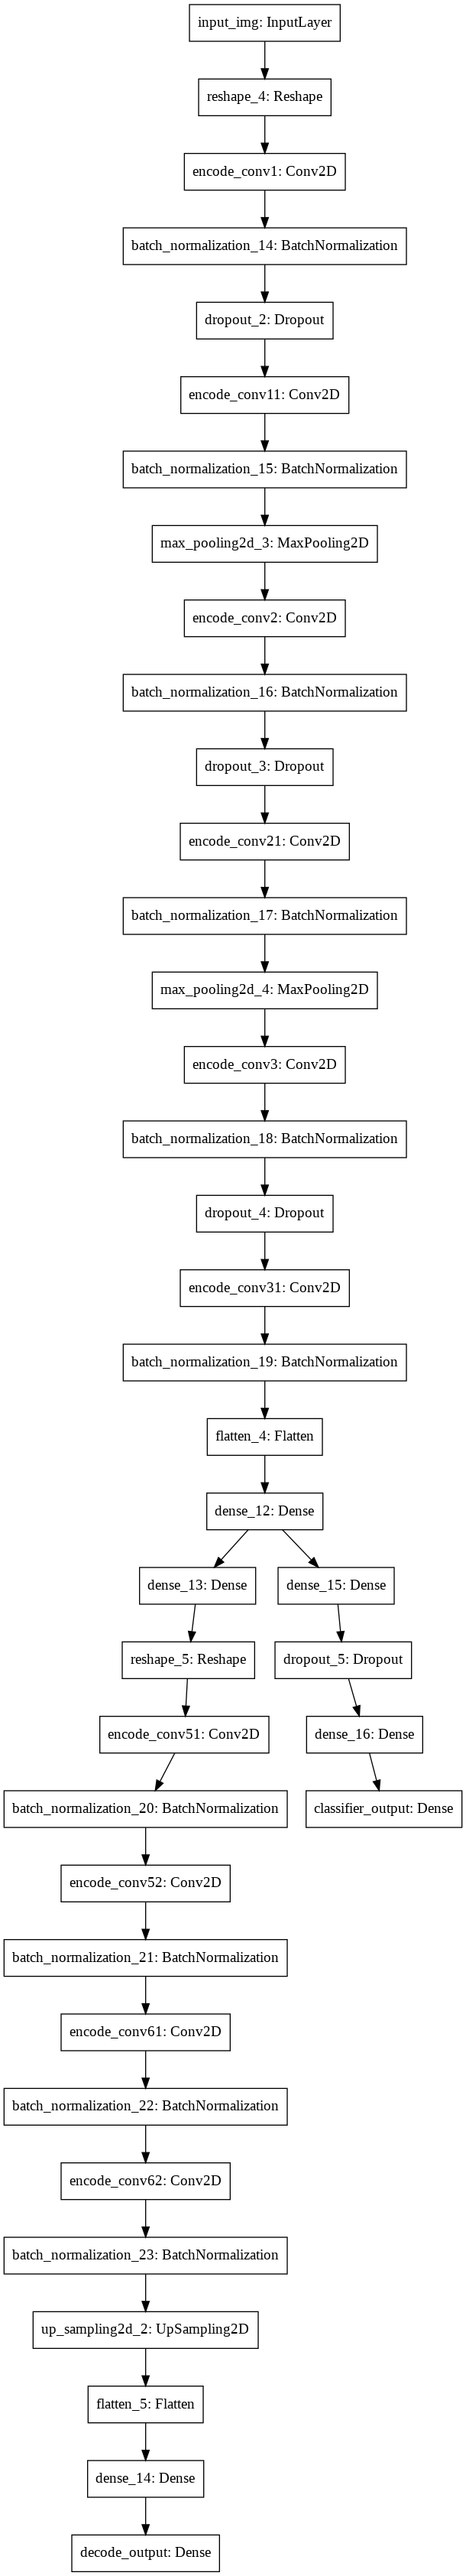

In [32]:
# print the network structure to a PDF file

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

SVG(model_to_dot(sae, show_shapes=False).create(prog='dot', format='svg'))

plot_model(
    model=sae, show_shapes=False,
    to_file='supervised_ae.png'
)

# you can find the file "supervised_ae.pdf" in the current directory.

### 4.2. Train the new model and tune the hyper-parameters

The new model has multiple output. Thus we specify **multiple** loss functions and their weights. 

In [34]:
from keras import optimizers

sae.compile(loss=['mean_squared_error', 'categorical_crossentropy'],
            loss_weights=[0.5, 0.5], # to be tuned
            optimizer=optimizers.RMSprop(lr=1E-4,decay=1e-6))

history = sae.fit(x_tr, [x_tr, y_tr], 
                  batch_size=32, 
                  epochs=100, 
                  validation_data=(x_val, [x_val, y_val]))

Train on 10000 samples, validate on 10000 samples
Epoch 1/100
10000/10000 [==============================] - 11s 1ms/step - loss: 0.7494 - decode_output_loss: 0.0689 - classifier_output_loss: 1.4300 - val_loss: 0.7876 - val_decode_output_loss: 0.0795 - val_classifier_output_loss: 1.4957
Epoch 2/100
10000/10000 [==============================] - 8s 847us/step - loss: 0.7001 - decode_output_loss: 0.0639 - classifier_output_loss: 1.3362 - val_loss: 0.7262 - val_decode_output_loss: 0.0685 - val_classifier_output_loss: 1.3840
Epoch 3/100
10000/10000 [==============================] - 8s 841us/step - loss: 0.6865 - decode_output_loss: 0.0630 - classifier_output_loss: 1.3099 - val_loss: 0.7244 - val_decode_output_loss: 0.0652 - val_classifier_output_loss: 1.3835
Epoch 4/100
10000/10000 [==============================] - 8s 844us/step - loss: 0.6767 - decode_output_loss: 0.0624 - classifier_output_loss: 1.2910 - val_loss: 0.7120 - val_decode_output_loss: 0.0654 - val_classifier_output_loss: 1.

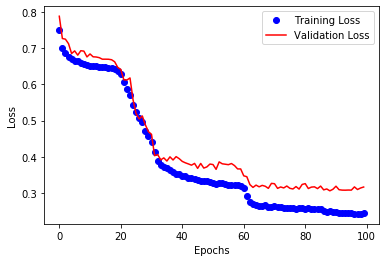

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Question

Do you think overfitting is happening? If yes, what can you do? Please make necessary changes to the supervised autoencoder network structure.

**Failing to add proper regularization will lose 1~2 scores.**

### 4.3. Visualize the reconstructed test images

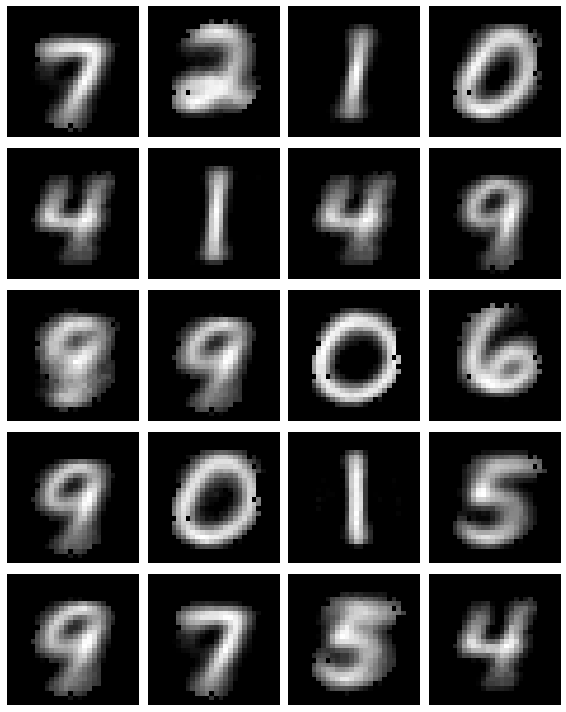

In [36]:
sae_output = sae.predict(x_test)[0].reshape((10000, 28, 28))

ROW = 5
COLUMN = 4

x = sae_output
fname = 'reconstruct_sae.pdf'

fig, axes = plt.subplots(nrows=ROW, ncols=COLUMN, figsize=(8, 10))
for ax, i in zip(axes.flat, numpy.arange(ROW*COLUMN)):
    image = x[i].reshape(28, 28)
    ax.imshow(image, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.savefig(fname)
plt.show()

### 4.4. Visualize the low-dimensional features

In [37]:
# build the encoder model
sae_encoder = models.Model(input_img, bottleneck)
sae_encoder.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       (None, 784)               0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
encode_conv1 (Conv2D)        (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_14 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
dropout_2 (Dropout)          (None, 28, 28, 32)        0         
_________________________________________________________________
encode_conv11 (Conv2D)       (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_15 (Batc (None, 28, 28, 32)        128 

Shape of encoded_test: (10000, 2)


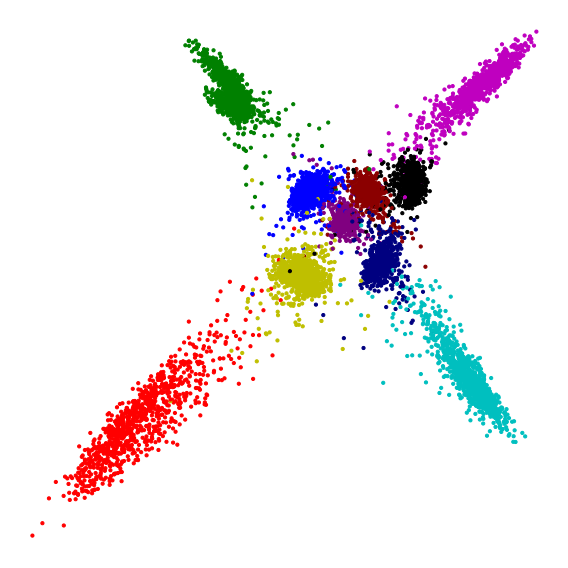

In [38]:
# extract test features
encoded_test = sae_encoder.predict(x_test)
print('Shape of encoded_test: ' + str(encoded_test.shape))

colors = numpy.array(['r', 'g', 'b', 'm', 'c', 'k', 'y', 'purple', 'darkred', 'navy'])
colors_test = colors[y_test]


import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8, 8))
plt.scatter(encoded_test[:, 0], encoded_test[:, 1], s=10, c=colors_test, edgecolors=colors_test)
plt.axis('off')
plt.tight_layout()
fname = 'sae_code.pdf'
plt.savefig(fname)

### 4.5. Are the learned low-dim features discriminative?

To find the answer, lets train a classifier on the training set (the extracted 2-dim features) and evaluation on the test set.


In [0]:
# extract 2D features from the training, validation, and test samples
f_tr = sae_encoder.predict(x_tr)
f_val = sae_encoder.predict(x_val)
f_te = sae_encoder.predict(x_test)

In [47]:
# build a classifier which takes the 2D features as input
from keras.layers import Dense, Input
from keras import models

input_feat = Input(shape=(2,))

dense_c1 = Dense(units=28*28*1)(input_feat)
dense_img = Reshape((28,28,1))(dense_c1)

# Conv1
conv1_c = Conv2D(32,(3,3),activation='relu',padding='same',name='conv1_c')(dense_img)
conv1_c = BatchNormalization()(conv1_c)
conv1_c = Conv2D(32,(3,3),activation='relu',padding='same',name='conv1_c')(dense_img)
conv1_c = BatchNormalization()(conv1_c)
conv1_c = Dropout(0.3)(conv1_c)

conv2_c = Conv2D(64,(3,3),activation='relu',padding='same',name='conv2_c')(conv1_c)
conv2_c = BatchNormalization()(conv2_c)
conv2_c = Conv2D(64,(3,3),activation='relu',padding='same',name='conv2_c')(conv1_c)
conv2_c = BatchNormalization()(conv2_c)
conv2_c = Dropout(0.3)(conv2_c)

conv3_c = Conv2D(128,(3,3),activation='relu',padding='same',name='conv3_c')(conv2_c)
conv3_c = BatchNormalization()(conv3_c)

dense1_c = Flatten()(conv3_c)
dense1_c = Dropout(0.5)(dense1_c)
dense2_c = Dense(128)(dense1_c)
output_c = Dense(10,activation='sigmoid')(dense2_c)


classifier = models.Model(input_feat, output_c)

classifier.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_24 (Dense)             (None, 784)               2352      
_________________________________________________________________
reshape_9 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv1_c (Conv2D)             (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_38 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
dropout_8 (Dropout)          (None, 28, 28, 32)        0         
_________________________________________________________________
conv2_c (Conv2D)             (None, 28, 28, 64)        184

In [48]:
classifier.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.RMSprop(lr=1E-5),
                  metrics=['acc'])

history = classifier.fit(f_tr, y_tr, 
                        batch_size=32, 
                        epochs=30, 
                        validation_data=(f_val, y_val))

Train on 10000 samples, validate on 10000 samples
Epoch 1/30
10000/10000 [==============================] - 10s 1ms/step - loss: 0.2914 - acc: 0.8671 - val_loss: 0.3908 - val_acc: 0.8430
Epoch 2/30
10000/10000 [==============================] - 7s 721us/step - loss: 0.1730 - acc: 0.9260 - val_loss: 0.4156 - val_acc: 0.8853
Epoch 3/30
10000/10000 [==============================] - 7s 724us/step - loss: 0.1697 - acc: 0.9415 - val_loss: 0.4180 - val_acc: 0.9029
Epoch 4/30
10000/10000 [==============================] - 7s 725us/step - loss: 0.1667 - acc: 0.9528 - val_loss: 0.4755 - val_acc: 0.9084
Epoch 5/30
10000/10000 [==============================] - 7s 728us/step - loss: 0.1735 - acc: 0.9550 - val_loss: 0.4377 - val_acc: 0.9240
Epoch 6/30
10000/10000 [==============================] - 7s 725us/step - loss: 0.1639 - acc: 0.9628 - val_loss: 0.4274 - val_acc: 0.9294
Epoch 7/30
10000/10000 [==============================] - 7s 720us/step - loss: 0.1679 - acc: 0.9671 - val_loss: 0.4426 - v

#### Remark:

The validation accuracy must be above 90%. It means the low-dim features learned by the supervised autoencoder are very effective.